In [1]:
import sys
sys.path.append('../utils')
sys.path.append('../core')
sys.path.append('../')
import numpy as np
import scipy
import tqdm
import utils
import geometry
import phantom_builder
from core import *
import open3d as o3d
from open3d import io, visualization

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import glob
import pydicom
import functools

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [8]:
voxel_size = np.array([0.0005, 0.0005, 0.0005])
surface_mesh = io.read_triangle_mesh("../assets/kidney_phantom_model/00_abdomen_cropped.obj")
body_mask = phantom_builder.voxelize(voxel_size[0], mesh=surface_mesh)

In [9]:
test_phantom = phantom.Phantom(source_path = None,
                               voxel_dims = (voxel_size[0], voxel_size[0], voxel_size[0]),
                               matrix_dims = body_mask.shape,
                               baseline = (1540, 1000),
                               seed = 5678,
                               )

# blood = tissue.Tissue(name='blood', c=1578, rho=1060, sigma=0, scale=0.00001, label=1)
# medulla = tissue.Tissue(name='renal_medulla', c=1564, rho=1044, sigma=40, scale=0.0001, label=2)
# cortex = tissue.Tissue(name='renal_cortex', c=1571.3, rho=1049, sigma=0, scale=0.0001, label=3)
# fat = tissue.Tissue(name='fat', c=1450, rho=920, sigma=5, scale=0.001, label=4)
# connective = tissue.Tissue(name='connective_tissue', c=1450, rho=1027, sigma=30, scale=0.0005, label=5)
# muscle = tissue.Tissue(name='muscle', c=1580, rho=1090, sigma=4, scale=0.001, label=6)
# bone = tissue.Tissue(name='bone', c=2500, rho=1800, sigma=0, scale=0.0001, label=7) # Running simulations with high sos tissue requires a larger grid_lambda parameter to maintain stability
# # skin = tissue.Tissue(name='skin', c=1624, rho=1109, sigma=1.3, scale=0.00001, label=8)
# # fat = tissue.Tissue(name='fat', c=1450, rho=920, sigma=0, scale=0.001, label=8)

kidney = tissue.Tissue(name='renal_cortex', c=1571.3, rho=1049, sigma=0, scale=0.0001, label=3)
blood = tissue.Tissue(name='blood', c=1578, rho=1060, sigma=0, scale=0.00001, label=1)
medulla = tissue.Tissue(name='renal_medulla', c=1564, rho=1044, sigma=0, scale=0.0001, label=2)
cortex = tissue.Tissue(name='renal_cortex', c=1571.3, rho=1049, sigma=0, scale=0.0001, label=3)
fat = tissue.Tissue(name='fat', c=1450, rho=920, sigma=30, scale=0.0001, label=4)
connective = tissue.Tissue(name='connective_tissue', c=1450, rho=1027, sigma=0, scale=0.0005, label=5)
muscle = tissue.Tissue(name='muscle', c=1580, rho=1090, sigma=4, scale=0.001, label=6)

# bone = tissue.Tissue(name='fat', c=1450, rho=920, sigma=30, scale=0.0001, label=4)
bone = tissue.Tissue(name='bone', c=2500, rho=1800, sigma=0, scale=0.0001, label=7) # Running simulations with high sos tissue requires a larger grid_lambda parameter to maintain stability
# skin = tissue.Tissue(name='skin', c=1624, rho=1109, sigma=1.3, scale=0.00001, label=8)
# fat = tissue.Tissue(name='fat', c=1450, rho=920, sigma=0, scale=0.001, label=8)


kidney_file_dir = "../assets/kidney_phantom_model/"
# kidney_tissue_list = [fat, muscle, muscle, bone, cortex, cortex, medulla, connective, blood]
kidney_tissue_list = [fat, muscle, muscle, bone, cortex, cortex, medulla, medulla, blood]

test_phantom.add_tissue(fat, mask=np.ones(test_phantom.matrix_dims))
test_phantom.build_organ_from_mesh(surface_mesh, voxel_size[0], kidney_tissue_list, dir_path = kidney_file_dir)
test_phantom.set_default_tissue('water')

Added fat
Added muscle
Added muscle
Added bone
[Open3D WARNING] Legacy mesh has more than 1 material which is not supported by Tensor-based meshes.
Added renal_cortex
[Open3D WARNING] Legacy mesh has more than 1 material which is not supported by Tensor-based meshes.
Added renal_cortex
[Open3D WARNING] Legacy mesh has more than 1 material which is not supported by Tensor-based meshes.
Added renal_medulla
[Open3D WARNING] Legacy mesh has more than 1 material which is not supported by Tensor-based meshes.
Added renal_medulla
[Open3D WARNING] Legacy mesh has more than 1 material which is not supported by Tensor-based meshes.
Added blood


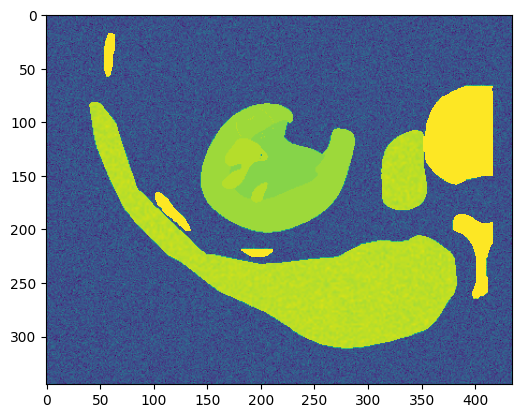

In [10]:
plt.imshow(test_phantom.get_complete()[0, :, :, 235], vmin=1400, vmax=1600)
# plt.imshow(body_mask[:,:, 250] * 1000, alpha=0.2, cmap='Reds_r')

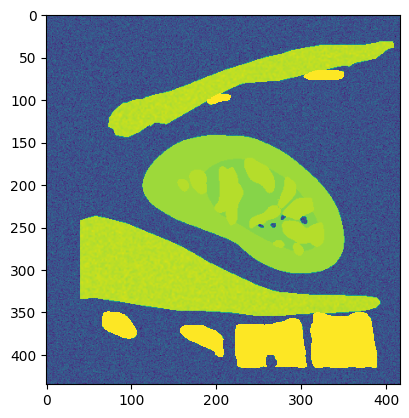

In [11]:
plt.imshow(test_phantom.get_complete()[0, 150, :, :], vmin=1400, vmax=1600)
# plt.imshow(body_mask[180,:, :] * 1000, alpha=0.2, cmap='Reds_r')

In [12]:
num_transducers = 1
# transducers = [transducer.Planewave(max_frequency=1e6,
#                                     elements = 32, 
#                                     width = 20e-3,
#                                     height =  20e-3,
#                                     sensor_sampling_scheme = 'not_centroid', 
#                                     sweep = np.pi/3,
#                                     ray_num = 3, 
#                                     imaging_ndims = 2,
#                                     focus_elevation = 20e-3,
#                                     ) for i in range(num_transducers)]

transducers = [transducer.Focused(max_frequency = 1e6,
                                  elements = 128, 
                                  width = 20e-3,
                                  height =  20e-3,
                                  sensor_sampling_scheme = 'not_centroid', 
                                  sweep = np.pi/2,
                                  ray_num = 64,
                                  imaging_ndims = 2,
                                  focus_azimuth = 120-3,
                                  focus_elevation = 120-3) for i in range(num_transducers)]


for t in transducers:
    t.make_sensor_coords(1540) # test_phantom.baseline[0]

test_transducer_set = transducer_set.TransducerSet(transducers, seed=8888)

In [13]:
pt, normal = test_transducer_set.place_on_mesh_voxel(0, surface_mesh,[220,70,340], voxel_size[0])
transducer_pose = geometry.Transform(rotation=(np.pi * 0.65, np.pi * 0.15, np.pi * 0.6), translation=pt)
test_transducer_set.assign_pose(0, transducer_pose)

In [14]:
# pt, normal = test_transducer_set.place_on_mesh_voxel(0, surface_mesh,[220,70,310], voxel_size[0])
# normal = -normal
# normal = np.array([normal[0] + 0.3, normal[1] - 0.3, normal[2] - 0.3])
# normal = normal / np.linalg.norm(normal)
# pose = geometry.Transform.make_from_heading_vector(normal, pt)
# theta = np.pi * .45
# about_nl_axis = geometry.Transform(rotation=tuple(theta * normal), translation=(0,0,0), about_axis=True)
# transducer_pose = about_nl_axis * pose
# test_transducer_set.assign_pose(0, transducer_pose)

In [15]:
test_sensor = sensor.Sensor(transducer_set=test_transducer_set, aperture_type='transmit_as_receive')

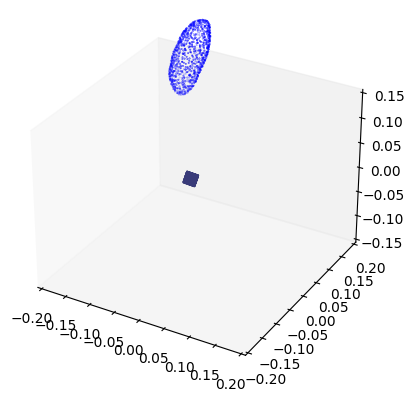

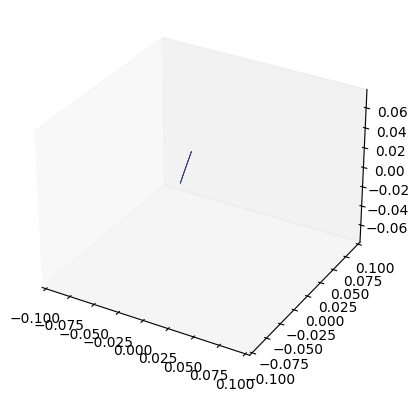

In [16]:
test_transducer_set.plot_transducer_coords(scale=0.2, phantom_coords = np.array((io.read_triangle_mesh("../assets/kidney_phantom/04_VH_M_kidney_capsule_L.obj")).sample_points_uniformly(1000).points))
test_transducer_set.plot_transducer_fovs()

In [17]:
simprops = simulation.SimProperties(
                grid_size   = (180e-3,90e-3,40e-3),
                voxel_size  = (0.5e-3,0.5e-3,0.5e-3),
                PML_size    = (32,8,8),
                PML_alpha   = 2,
                t_end       = 12e-5,           # [s]
                bona        = 6,               # parameter b/a determining degree of nonlinear acoustic effects
                alpha_coeff = 0.5, 	           # [dB/(MHz^y cm)]
                alpha_power = 1.5,
                grid_lambda = 2,               # 
                )

In [18]:
test_experiment = experiment.Experiment(
                 simulation_path = '../experiment_files/kidney_experiment_02',
                 sim_properties  = simprops,
                 phantom         = test_phantom,
                 transducer_set  = test_transducer_set,
                 sensor          = test_sensor,
                 nodes           = 1,
                 results         = None,
                 indices         = None,
                 workers         = 5,
                 additional_keys = []
                 )

test_experiment.save()

workers specifies the number of simultaneous simulations running on a single gpu node, setting workers higher than 3 will likely use more RAM without decreasing overall runtime


In [19]:
sensor_coord = np.mean(test_sensor.sensor_coords, axis=0) / voxel_size + np.array(test_phantom.matrix_dims)/2
sensor_coord

array([226.22904241,  62.82119334, 339.50161505])

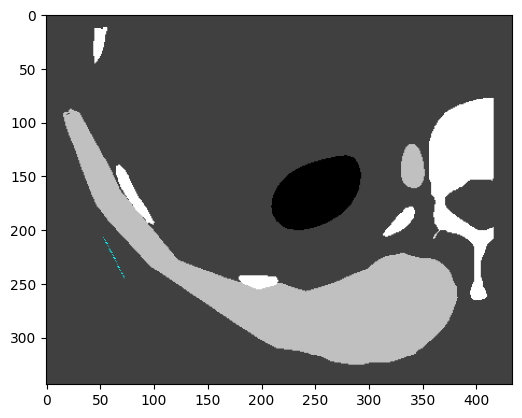

In [20]:
test_experiment.visualize_sensor_mask(index=[slice(0, -1, 1), slice(0, -1, 1), int(np.round(sensor_coord[2]))], body_surface_mask=body_mask)

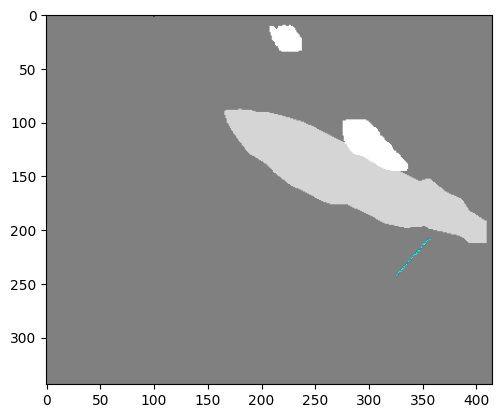

In [21]:
test_experiment.visualize_sensor_mask(index=[slice(0, -1, 1),int(np.round(sensor_coord[1])), slice(0, -1, 1), ], body_surface_mask=body_mask)

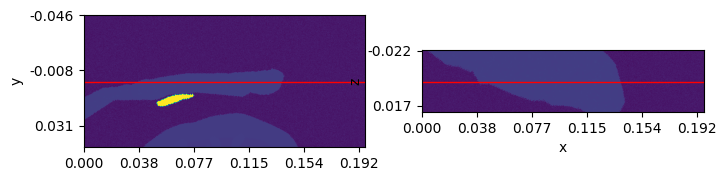

In [22]:
test_experiment.plot_ray_path(0)

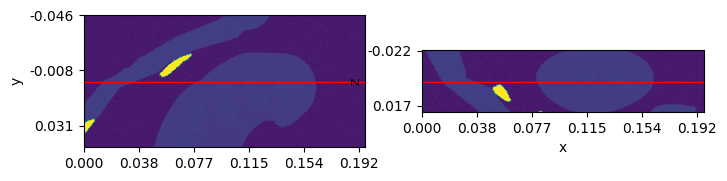

In [23]:
test_experiment.plot_ray_path(15)

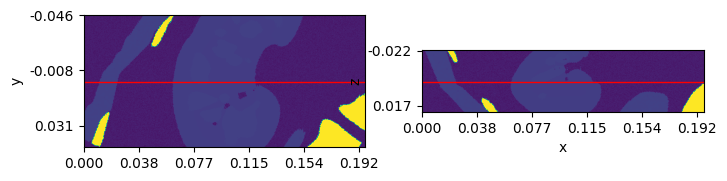

In [24]:
test_experiment.plot_ray_path(31)

In [25]:
# test_experiment.plot_ray_path(44)

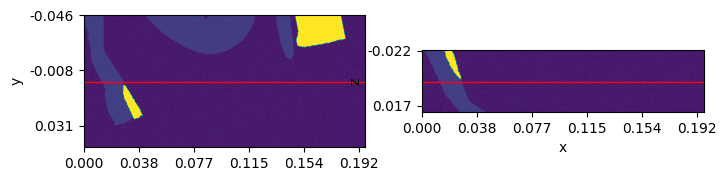

In [26]:
test_experiment.plot_ray_path(-1)

In [27]:
test_experiment = experiment.Experiment.load('../experiment_files/kidney_experiment_02')
test_experiment.run(dry=True)

dry run of simulation


100%|██████████| 1/1 [00:00<00:00,  4.20it/s]


In [28]:
test_experiment.run(repeat=True)

running with 5 workers

preparation for sim    0 completed in 41.08 seconds
preparation for sim   16 completed in 41.25 seconds
preparation for sim   48 completed in 41.20 seconds
preparation for sim   32 completed in 41.29 seconds
preparation for sim    1 completed in 42.41 seconds
preparation for sim   17 completed in 42.49 seconds
preparation for sim   49 completed in 42.80 seconds
preparation for sim   33 completed in 41.02 seconds
simulation             0 completed in 53.06 seconds
simulation            16 completed in 51.39 seconds
simulation            48 completed in 51.37 seconds
simulation            32 completed in 51.44 seconds
preparation for sim   50 completed in 41.11 seconds
preparation for sim   18 completed in 41.61 seconds
preparation for sim   34 completed in 40.73 seconds
preparation for sim    2 completed in 40.85 seconds
simulation             1 completed in 53.20 seconds
simulation            17 completed in 51.44 seconds
simulation            49 completed in 51

In [ ]:
test_experiment.add_results()

In [ ]:
test_reconstruction = reconstruction.DAS(experiment=test_experiment)

In [ ]:
signals = test_reconstruction.get_signals(dimensions=2, matsize=128, downsample=0.5, workers=16, tgc=10)

In [ ]:
plt.imshow(signals[0], vmax=40000)


In [ ]:
plt.plot(test_experiment.results[9][1][0])

In [ ]:
test_experiment.results[0][1][0]